# Master Dataset

The goal of this notebook is to gather, clean and join all relevant gas and power price data with the two provided competitor datasets. The output of this notebook is two csv files, one for gas and one for power, containing additional features, cleaned data and correct indexing and data types which can be used for analysis. 

In [108]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

In [109]:
#path to the data folder, edit if necesssary
path = "./data/Provided Data/"
generatedpath = "./data/Generated Data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"

#Gas Prices 
spot_gas = "eex_spot_gas.csv"
d_ahead_gas = "eex_gas_d.csv"
m_ahead_gas = "eex_gas_m.csv"
y_ahead_gas = "eex_gas_y.csv"

#Power Prices
spot_power = "epex_spot_power.csv"
d_ahead_peak = "eex_power_peak_d.csv"
m_ahead_peak = "eex_power_peak_m.csv"
y_ahead_peak = "eex_power_peak_y.csv"
d_ahead_base = "eex_power_base_d.csv"
m_ahead_base = "eex_power_base_m.csv"
y_ahead_base = "eex_power_base_y.csv"

In [110]:
#Reading in original datasets
competitors_power = pd.read_csv(path + file_power)
competitors_gas = pd.read_csv(path + file_gas)

In [111]:
#Averaging out exact duplicate rows 

#Defining groupby cols
gb_cols = ['date_valid_from',
            'date_valid_to',
           'post_code', 
           'city', 
           'energy', 
           'consumption_range_kwh', 
           'supplier', 
           'tariff']

agg_dict = {'rank':'mean',
           'price_year_eur':'mean'}


df_power = competitors_power.groupby(gb_cols).agg(agg_dict).reset_index()
df_gas = competitors_gas.groupby(gb_cols).agg(agg_dict).reset_index()

In [112]:
#Joining Price Data
df_spot_power = pd.read_csv(path + spot_power, usecols = [0,1])
df_m_ahead_peak = pd.read_csv(path + m_ahead_peak, usecols = [0,2,7])
df_m_ahead_base = pd.read_csv(path + m_ahead_base, usecols = [0,2,7])
df_y_ahead_peak = pd.read_csv(path + y_ahead_peak, usecols = [0,1,2,3])
df_y_ahead_base = pd.read_csv(path + y_ahead_base, usecols = [0,1,2,3])
df_d_ahead_peak = pd.read_csv(path + d_ahead_peak, usecols = [0,1])
df_d_ahead_base = pd.read_csv(path + d_ahead_base, usecols = [0,1])

In [113]:
#Renaming columns
df_spot_power.rename(columns = {'d': 'spot'}, inplace = True)
df_y_ahead_peak.rename(columns = {'y01': 'y_ahead_peak',
                                 'y02': '2y_ahead_peak',
                                 'y03': '3y_ahead_peak'}, inplace = True)
df_y_ahead_base.rename(columns = {'y01': 'y_ahead_base',
                                 'y02': '2y_ahead_base',
                                 'y03': '3y_ahead_base'}, inplace = True)
df_d_ahead_peak.rename(columns = {'d00': 'd_ahead_peak'}, inplace = True)
df_d_ahead_base.rename(columns = {'d00': 'd_ahead_base'}, inplace = True)
df_m_ahead_base.rename(columns = {'M01': 'm_ahead_base',
                                 'M06': '6m_ahead_base'}, inplace = True)
df_m_ahead_peak.rename(columns = {'m01': 'm_ahead_peak',
                                 'm06': '6m_ahead_peak'}, inplace = True)

In [114]:
#Indexing Spot Price Data
df_spot_power.time = pd.to_datetime(df_spot_power.time)
df_spot_power['Dates'] = df_spot_power['time'].dt.date
df_spot_power.set_index('time', inplace = True)

In [115]:
#Generating Daily Peak and Base Prices
df_spot_power_peak = df_spot_power.between_time("08:00", "19:59")
df_spot_power_base = df_spot_power.groupby('Dates').mean()
df_spot_power_peak = df_spot_power_peak.groupby('Dates').mean()

#Renaming the columns and joining
df_spot_power_peak.rename(columns = {'spot': 'spot_peak'}, inplace = True)
df_spot_power_base.rename(columns = {'spot': 'spot_base'}, inplace = True)

#Joining the dataset
df_spot_power = pd.merge(df_spot_power_peak,df_spot_power_base, how='inner', left_index=True, right_index=True)


In [116]:
from datetime import datetime, timedelta
#Joining all price data into one power price df
power_price_dfs = [df_y_ahead_peak, df_y_ahead_base, df_d_ahead_peak, df_d_ahead_base, df_m_ahead_base, df_m_ahead_peak]

for df in power_price_dfs:
    
    df.set_index(pd.to_datetime(df.date), inplace = True)
    df.drop(columns = ['date'], inplace = True)
    df_spot_power = df_spot_power.join(df)
    
df_power_prices = df_spot_power
df_power_prices.ffill(inplace = True)

In [117]:
#Converting power prices to per kwh prices
df_power_prices = df_power_prices / 1000
df_power_prices['avg_price'] = df_power_prices.apply(lambda x: x.mean(), axis = 1)
df_power_prices

,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base,m_ahead_base,6m_ahead_base,m_ahead_peak,6m_ahead_peak,avg_price
Dates,,,,,,,,,,,,,,,
2000-06-16,0.020503,0.017126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018815
2000-06-17,0.015180,0.013297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014239
2000-06-18,0.012578,0.011402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011990
2000-06-19,0.021919,0.017666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019793
2000-06-20,0.022857,0.018364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-10,0.186518,0.162090,0.58164,0.35367,0.25450,0.42700,0.27000,0.19500,0.18652,0.16209,0.34489,0.38971,0.47080,0.49209,0.319751
2022-10-11,0.291781,0.259874,0.58540,0.35550,0.25350,0.43564,0.27000,0.19492,0.29178,0.25987,0.34531,0.39827,0.46967,0.49292,0.350317
2022-10-12,0.299797,0.282536,0.59000,0.35546,0.25361,0.43400,0.26800,0.19388,0.29980,0.28254,0.34197,0.38953,0.45450,0.48541,0.352217


In [118]:
#Getting gas price data
df_spot_gas = pd.read_csv(path + spot_gas, usecols = [0,1])
df_y_ahead_gas = pd.read_csv(path + y_ahead_gas, usecols = [0,1,2,3])
df_d_ahead_gas = pd.read_csv(path + d_ahead_gas, usecols = [0,1])
df_m_ahead_gas = pd.read_csv(path + m_ahead_gas, usecols = [0, 2, 5])

In [119]:
#Renaming columns
df_spot_gas.rename(columns = {'d': 'spot'}, inplace = True)
df_y_ahead_gas.rename(columns = {'y01': 'y_ahead_gas',
                                'y02': '2y_ahead_gas',
                                'y03': '3y_ahead_gas'}, inplace = True)
df_d_ahead_gas.rename(columns = {'d00': 'd_ahead_gas'}, inplace = True)
df_m_ahead_gas.rename(columns = {'m01': 'm_ahead_gas',
                                'm04': '4m_ahead_gas'}, inplace = True)

In [120]:
#Joining all gas price data into competitor dataset
from datetime import datetime, timedelta

#Setting join date as index for joining to avoid lookahead bias
df_gas.date_valid_from = pd.to_datetime(df_gas.date_valid_from)
df_gas.index = df_gas.date_valid_from - timedelta(days = 1)
df_gas

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur
date_valid_from,,,,,,,,,,
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,1000,Levante,Sawsbuck,1.0,131.30
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,1500,Levante,Sawsbuck,1.0,160.95
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2000,Levante,Sawsbuck,1.0,190.60
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2300,Levante,Sawsbuck,1.0,208.39
2021-05-20,2021-05-21,2021-09-01,1309,Dresden,gas,2500,Levante,Sawsbuck,1.0,220.25
...,...,...,...,...,...,...,...,...,...,...
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Belat,Carracosta,5.0,149087.87
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Pulenat,Araquanid,6.0,149525.13
2022-10-14,2022-10-15,9999-12-31,99089,Erfurt,gas,500000,Pulenat,Perrserker,4.0,148990.13


In [121]:
#Joining all price data
df_spot_gas.set_index('date', inplace = True)
df_y_ahead_gas.set_index('date', inplace = True)
df_m_ahead_gas.set_index('date', inplace = True)
df_d_ahead_gas.set_index('date', inplace = True)

#Joining all price data into same dataframe
gas_price_dfs = [df_y_ahead_gas, df_d_ahead_gas,df_m_ahead_gas]

df_gas_prices = df_spot_gas

for df in gas_price_dfs:
    df_gas_prices = df_gas_prices.join(df)
    
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)

#Using follow fill for price imputation
df_gas_prices.ffill(inplace = True)

In [122]:
#Converting gas prices to per kwh prices
df_gas_prices = df_gas_prices / 1000
df_gas_prices['avg_price'] = df_gas_prices.apply(lambda x: x.mean(), axis = 1)
df_gas_prices

,spot,y_ahead_gas,2y_ahead_gas,3y_ahead_gas,d_ahead_gas,m_ahead_gas,4m_ahead_gas,avg_price
date,,,,,,,,
2022-10-14,0.098389,NaN,NaN,NaN,NaN,NaN,NaN,0.098389
2022-10-13,0.105416,0.162270,0.120700,0.085400,0.105416,0.154830,0.173422,0.129636
2022-10-12,0.106853,0.169780,0.125533,0.087759,0.106853,0.161281,0.176522,0.133512
2022-10-11,0.105449,0.174238,0.127650,0.089650,0.105449,0.158250,0.178962,0.134235
2022-10-10,0.119323,0.171770,0.123450,0.088330,0.119323,0.154982,0.174634,0.135973
...,...,...,...,...,...,...,...,...
2011-06-04,0.022960,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.025908
2011-06-03,0.022990,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.025912
2011-06-02,0.023170,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.025938


In [123]:
#Creating Supplier Strategy Index (Index 1 - 5 and 5 for suppliers showing up in the top 50 less than 10000 times)
gas_suppliers = df_gas[['supplier', 'rank']]
power_suppliers = df_power[['supplier', 'rank']]
gas_suppliers

,supplier,rank
date_valid_from,,
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
...,...,...
2022-10-14,Belat,5.0
2022-10-14,Pulenat,6.0
2022-10-14,Pulenat,4.0


In [124]:
#Adding price / kwh 
df_gas['price_kwh'] = df_gas['price_year_eur'] / df_gas['consumption_range_kwh']
df_power['price_kwh'] = df_power['price_year_eur'] / df_power['consumption_range_kwh']

df_power

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,price_kwh
0,2021-05-25,2021-09-21,51103,Köln,power,500,Criador,Meltan,3.0,260.25,0.520500
1,2021-05-25,2021-09-21,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,0.515700
2,2021-05-25,2021-09-21,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,0.515700
3,2021-05-25,2021-09-22,51103,Köln,power,250,Criador,Meltan,3.0,187.62,0.750480
4,2021-05-25,2021-09-22,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,0.745680
...,...,...,...,...,...,...,...,...,...,...,...
33161801,2022-10-15,9999-12-31,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,0.771421
33161802,2022-10-15,9999-12-31,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,0.781322
33161803,2022-10-15,9999-12-31,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,0.764625
33161804,2022-10-15,9999-12-31,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,0.678392


In [125]:
#Valid suppliers
gas_sup_counts = pd.DataFrame(gas_suppliers['supplier'].value_counts())
pow_sup_counts = pd.DataFrame(power_suppliers['supplier'].value_counts()) 
no_strat_gas_suppliers = gas_sup_counts.loc[gas_sup_counts.supplier < 10000]
no_strat_pow_suppliers = pow_sup_counts.loc[pow_sup_counts.supplier < 10000]

(array([ 0.,  2.,  4.,  6.,  2.,  5.,  8., 12., 17.,  4., 10.,  5.,  7.,
         4.,  3.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.  ,  3.45,  5.9 ,  8.35, 10.8 , 13.25, 15.7 , 18.15, 20.6 ,
        23.05, 25.5 , 27.95, 30.4 , 32.85, 35.3 , 37.75, 40.2 , 42.65,
        45.1 , 47.55, 50.  ]),
 <BarContainer object of 20 artists>)

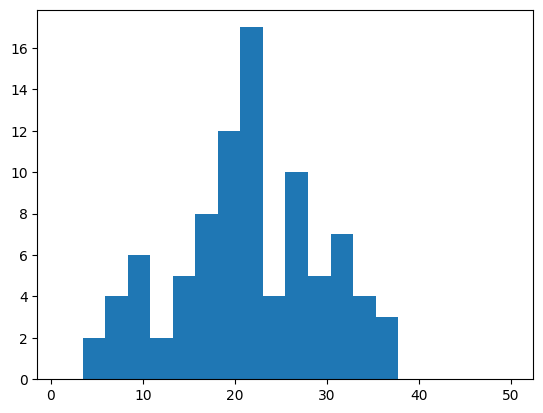

In [141]:
average_gas_ranks = pd.DataFrame(df_gas.loc[~df_gas['supplier'].isin(no_strat_gas_suppliers.index)].groupby('supplier')['rank'].mean())
average_power_ranks = pd.DataFrame(df_power.loc[~df_power['supplier'].isin(no_strat_pow_suppliers.index)].groupby('supplier')['rank'].mean())

plt.hist(average_gas_ranks, range = (1, 50), bins = 20)
#plt.hist(average_power_ranks, range = (1, 50), bins = 20)


In [127]:
bins = [1,2,3,4,5]
cutoffs = [0, 9, 19, 29, 39, 49]
average_gas_ranks['strat_index'] = pd.cut(average_gas_ranks['rank'], bins = cutoffs, labels = bins)
average_power_ranks['strat_index'] = pd.cut(average_power_ranks['rank'], bins = cutoffs, labels = bins)

In [128]:
#Adding Strategy Indices to Datasets
df_power = df_power.merge(average_power_ranks[['strat_index']], how = 'left', left_on = 'supplier', right_on = average_power_ranks.index)
df_gas = df_gas.merge(average_gas_ranks[['strat_index']], how = 'left', left_on = 'supplier', right_on = average_gas_ranks.index)

In [129]:
#Converting strat indices to floats
df_power['strat_index'] = df_power['strat_index'].astype('float64')
df_gas['strat_index'] = df_gas['strat_index'].astype('float64')

In [130]:
#Filling Strategy Index NAs with index value 0, since they are outside of the top 50 for most postcodes
df_power['strat_index'] = df_power['strat_index'].fillna(0).astype('int64')
df_gas['strat_index'] = df_gas['strat_index'].fillna(0).astype('int64')

In [131]:
#Replacing invalid date_valid_to dates with max date in date_valid_from

max_valid_to = df_power.date_valid_from.max()
df_gas['date_valid_to'] = df_gas['date_valid_to'].str.replace('9999-12-31', str(max_valid_to))
df_power['date_valid_to'] = df_power['date_valid_to'].str.replace('9999-12-31', str(max_valid_to))

#Converting validity dates to datetimes
df_gas['date_valid_to'] = pd.to_datetime(df_gas['date_valid_to'])
df_power['date_valid_to'] = pd.to_datetime(df_power['date_valid_to'])

In [133]:
#Looking at price volatility across supplier indices
df_power_1 = df_power.loc[df_power.strat_index == 1].copy()
df_power_2 = df_power.loc[df_power.strat_index == 2].copy()
df_power_3 = df_power.loc[df_power.strat_index == 3].copy()
df_power_4 = df_power.loc[df_power.strat_index == 4].copy()
df_power_5 = df_power.loc[df_power.strat_index == 5].copy()

In [134]:
#Looking at price volatility across supplier indices
df_gas_1 = df_gas.loc[df_gas.strat_index == 1].copy()
df_gas_2 = df_gas.loc[df_gas.strat_index == 2].copy()
df_gas_3 = df_gas.loc[df_gas.strat_index == 3].copy()
df_gas_4 = df_gas.loc[df_gas.strat_index == 4].copy()
df_gas_5 = df_gas.loc[df_gas.strat_index == 5].copy()

In [138]:
def getDailyData(res) -> pd.DataFrame:
    res = res[['price_kwh', 'date_valid_from', 'date_valid_to']]

    res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)
    res = res.explode("valid_range").copy()

    #Aggregating for mean household prices per day
    res = res.groupby('valid_range').agg({'price_kwh':'mean'})
    return res

#Getting daily indexed agg price data and margins (takes 40 mins)
df_power_1 = getDailyData(df_power_1)
print('P1')
df_power_2 = getDailyData(df_power_2)
print('P2')
df_power_3 = getDailyData(df_power_3)
print('P3')
df_power_4 = getDailyData(df_power_4)
print('P4')
df_power_5 = getDailyData(df_power_5)
print('P5')

#Getting daily indexed agg price data and margins (takes 40 mins)
df_gas_1 = getDailyData(df_gas_1)
print('G1')
df_gas_2 = getDailyData(df_gas_2)
print('G2')
df_gas_3 = getDailyData(df_gas_3)
print('G3')
df_gas_4 = getDailyData(df_gas_4)
print('G4')

#G5 is empty

/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


P1


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


P2


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


P3


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


P4


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


P5


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


G1


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


G2


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


G3


/var/folders/gm/ndtw23hd4g508cgk1jbt_b640000gn/T/ipykernel_73385/2150353196.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res["valid_range"] = res.apply(lambda x: pd.date_range(x["date_valid_from"], x["date_valid_to"]), axis=1)


G4


ValueError: Cannot set a DataFrame with multiple columns to the single column valid_range

In [178]:
#Joining all price data into same dataframe
power_dfs = [df_power_2, df_power_3, df_power_4, df_power_5]
gas_dfs = [df_gas_2, df_gas_3, df_gas_4]

df_gas_strat_prices = df_gas_1
df_pow_strat_prices = df_power_1

for i, df in enumerate(gas_dfs):
    df_gas_strat_prices = df_gas_strat_prices.join(df, rsuffix= '_' + str(i + 2), how = 'outer')

for i, df in enumerate(power_dfs):
    df_pow_strat_prices = df_pow_strat_prices.join(df, rsuffix= '_' + str(i + 2), how = 'outer')
    
df_pow_strat_prices = df_pow_strat_prices.join(df_power_prices)
df_gas_strat_prices = df_gas_strat_prices.join(df_gas_prices)
df_gas_strat_prices

,price_kwh,price_kwh_2,price_kwh_3,price_kwh_4,spot,y_ahead_gas,2y_ahead_gas,3y_ahead_gas,d_ahead_gas,m_ahead_gas,4m_ahead_gas,avg_price
valid_range,,,,,,,,,,,,
2021-05-21,NaN,NaN,0.097294,NaN,0.024226,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.026089
2021-05-22,NaN,NaN,0.097926,NaN,0.025031,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.026204
2021-05-23,NaN,NaN,0.097926,NaN,0.025031,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.026204
2021-05-24,NaN,NaN,0.097926,NaN,0.025050,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.026206
2021-05-25,NaN,NaN,0.097926,NaN,0.024835,0.024524,0.019750,0.017899,0.031691,0.032243,0.032287,0.026176
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,0.271499,0.332763,0.285826,NaN,0.105449,0.174238,0.127650,0.089650,0.105449,0.158250,0.178962,0.134235
2022-10-12,0.271499,0.339918,0.285826,NaN,0.106853,0.169780,0.125533,0.087759,0.106853,0.161281,0.176522,0.133512
2022-10-13,0.271499,0.308512,0.285826,NaN,0.105416,0.162270,0.120700,0.085400,0.105416,0.154830,0.173422,0.129636


In [179]:
#Writing strategy index csvs to disk
df_pow_strat_prices.to_csv(generatedpath + "Strat_" + file_power)
df_gas_strat_prices.to_csv(generatedpath + "Strat_" + file_gas)

In [143]:
df_gas.to_csv(generatedpath + "master_" + file_gas, index = False)
df_power.to_csv(generatedpath + "master_" + file_power, index = False)

In [180]:
df_power_prices.to_csv(generatedpath + 'power_prices.csv')

In [181]:
df_gas_prices.to_csv(generatedpath + 'gas_prices.csv')

In [183]:
df_power

,date_valid_from,date_valid_to,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,price_kwh,strat_index
0,2021-05-25,2021-09-21,51103,Köln,power,500,Criador,Meltan,3.0,260.25,0.520500,2
1,2021-05-25,2021-09-21,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,0.515700,2
2,2021-05-25,2021-09-21,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,0.515700,2
3,2021-05-25,2021-09-22,51103,Köln,power,250,Criador,Meltan,3.0,187.62,0.750480,2
4,2021-05-25,2021-09-22,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,0.745680,2
...,...,...,...,...,...,...,...,...,...,...,...,...
33161801,2022-10-15,2022-10-15,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,0.771421,2
33161802,2022-10-15,2022-10-15,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,0.781322,2
33161803,2022-10-15,2022-10-15,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,0.764625,2
33161804,2022-10-15,2022-10-15,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,0.678392,3
